# Costumer Segmentation
## In this project we want to extract the number of costumer types, i.e., costumer segmentation by using the KMeans algorithm (unsupervised ML) to cluster the data.


### 1)Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")


### 2) Load the data and study the quality

In [2]:
data=pd.read_csv('Mall_Customers.csv')
print(data.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


The number of rows are: 200
The number of columns are: 5
Column names: ['CustomerID' 'Gender' 'Age' 'Annual Income (k$)' 'Spending Score (1-100)']


Inspect the types of each columns
CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object


Inspect the missing data
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


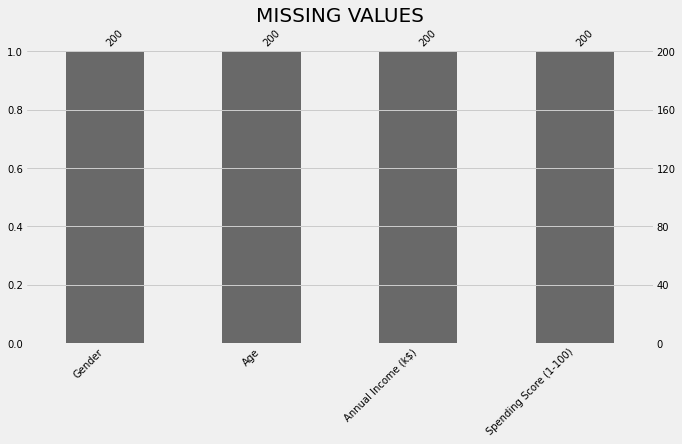

In [3]:
print('The number of rows are:',data.shape[0])
print('The number of columns are:',data.shape[1])
print('Column names:', data.columns.values)
print('\n')
print('Inspect the types of each columns')
print(data.dtypes)
print('\n')
print('Inspect the missing data')
plt.style.use('fivethirtyeight')

#Delete the CustomerID columns because its irrelevant
data.drop(columns='CustomerID',inplace=True)

#plot the missing data to visualize more easily 
print(data.isna().sum())

msno.bar(data,fontsize=10,figsize=(10,5))
plt.title('MISSING VALUES',fontsize=20)
plt.show()

As we can see we dont have any missing values but we need the change the values of the gender column. 

0: Male
1: Female

In [4]:
data['Gender'].replace({'Male':0,'Female':1},inplace=True)
print(data.head())
print('Inspect if the type of the columns corresponds to the new values')
print(data.dtypes)

   Gender  Age  Annual Income (k$)  Spending Score (1-100)
0       0   19                  15                      39
1       0   21                  15                      81
2       1   20                  16                       6
3       1   23                  16                      77
4       1   31                  17                      40
Inspect if the type of the columns corresponds to the new values
Gender                    int64
Age                       int64
Annual Income (k$)        int64
Spending Score (1-100)    int64
dtype: object


### 3)Univariate Analysis

In [5]:
print(data.describe())

           Gender         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean     0.560000   38.850000           60.560000               50.200000
std      0.497633   13.969007           26.264721               25.823522
min      0.000000   18.000000           15.000000                1.000000
25%      0.000000   28.750000           41.500000               34.750000
50%      1.000000   36.000000           61.500000               50.000000
75%      1.000000   49.000000           78.000000               73.000000
max      1.000000   70.000000          137.000000               99.000000


we're going to visualize each column 

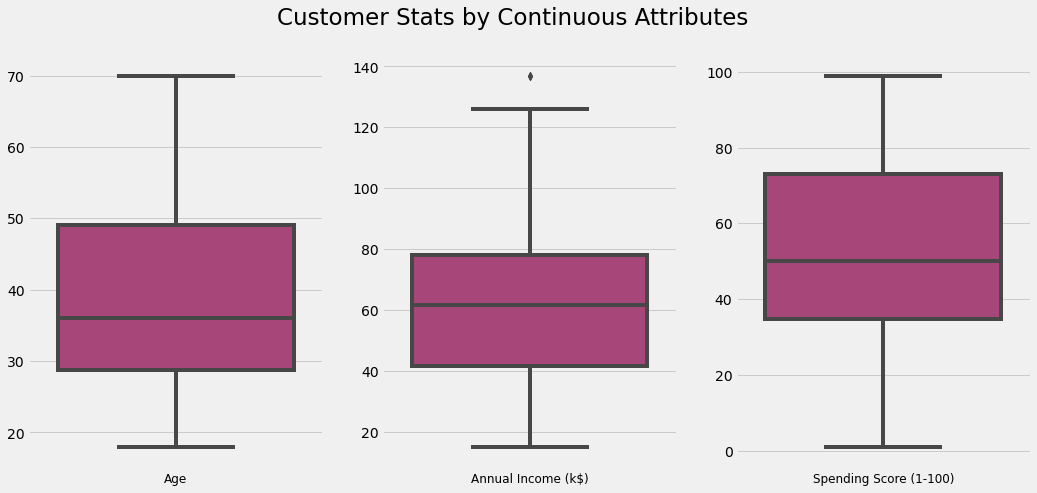

In [6]:
#continuous variables 
plt.style.use('fivethirtyeight')

fig, axes = plt.subplots(1, 3, figsize=(16, 7))
fig.suptitle('Customer Stats by Continuous Attributes',fontsize=23)

sns.boxplot(ax=axes[0], data=data ,y='Age',palette='magma')
axes[0].set_ylabel('')
axes[0].set_xlabel('Age',fontsize=12)

sns.boxplot(ax=axes[1], data=data ,y='Annual Income (k$)',palette='magma')
axes[1].set_ylabel('')
axes[1].set_xlabel('Annual Income (k$)',fontsize=12)

sns.boxplot(ax=axes[2], data=data ,y='Spending Score (1-100)',palette='magma')
axes[2].set_ylabel('')
axes[2].set_xlabel('Spending Score (1-100)',fontsize=12)
plt.show()

Age and Annual Income columns have most of the values in the mid-low area wich tells us that these columns dont have a lot of variability and the income column has an outlier

For the Spending Score we have most of the data in the top mid-top area wich tells us that the customers tend to spend more money

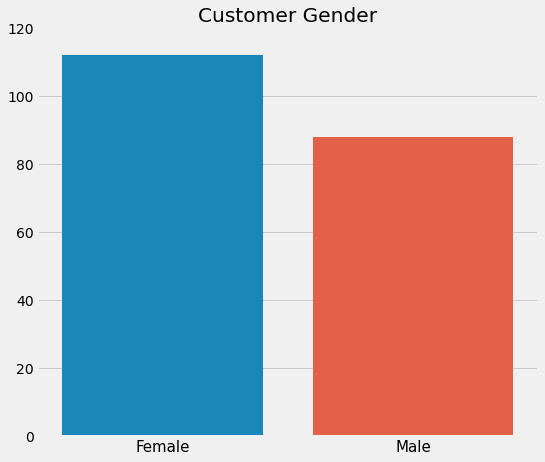

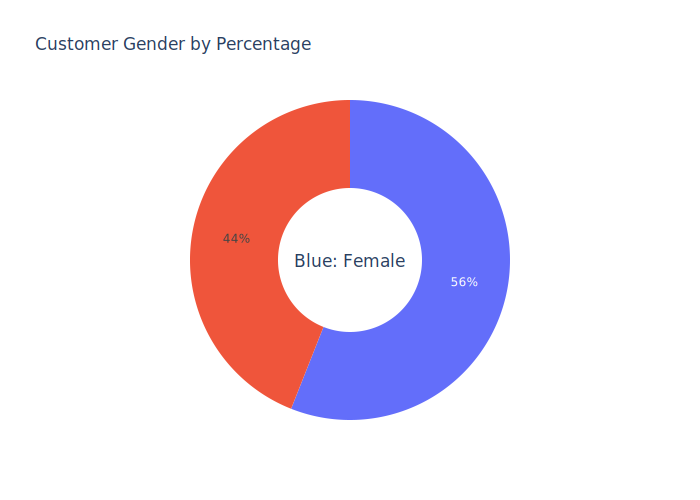

In [7]:
gen=data.Gender.value_counts()

fig, ax1 = plt.subplots(1, 1, figsize=(8, 7))
g=sns.barplot(x=gen.index,y=gen.values,order=[1,0],ax=ax1)
g.set_title('Customer Gender')
g.set_ylim(0,120)
g.set_xticklabels(['Female','Male'],fontsize=15)
plt.show()

g1=px.pie(values=gen.values,names=gen.index,title='Customer Gender by Percentage',hole=0.45,)
g1.update_layout(annotations=[dict(text='Blue: Female', x=0.5, y=0.5, font_size=17, showarrow=False)],                                    showlegend=False)
g1.show('svg')


As we can see most of the data population are females.

*For this analysis we're going to use only continuous variables so we drop gender*

In [8]:
data.drop(columns='Gender',inplace=True)

### 4) bivariate analysis
hacer un matrix correlation espues un heatmap y por ultimo un pairplot con gender como hue

### 5) Customer Segmentation

Search for the optimum cluster number using the elbow method between 3 options 

1° Annual income and Spending Score

2° Age and Annual income

3° Spending Score and Age

4° Annual income and Spending Score and Age

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()


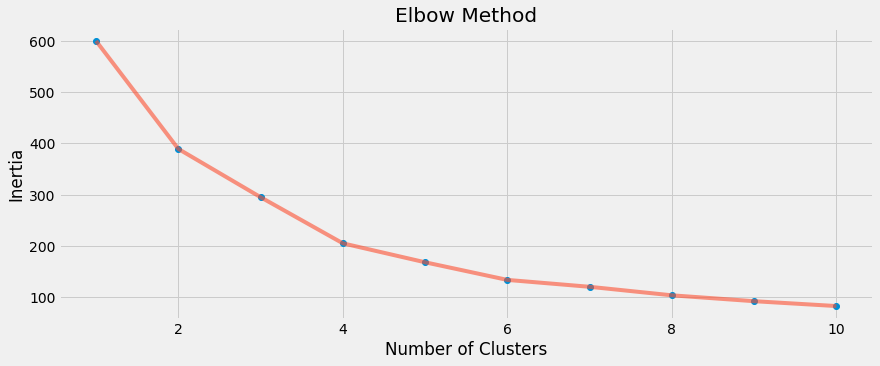

In [10]:
#Annual income and Spending Score
X=data.values
inertia1=[]
for i in range(1,11):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=42)
    X1=scaler.fit_transform(X)
    kmeans.fit(X1)
    inertia1.append(kmeans.inertia_)

plt.figure(1 , figsize = (13 ,5))
plt.plot(np.arange(1 , 11) , inertia1 , 'o')
plt.plot(np.arange(1 , 11) , inertia1 , '-' , alpha = 0.6)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

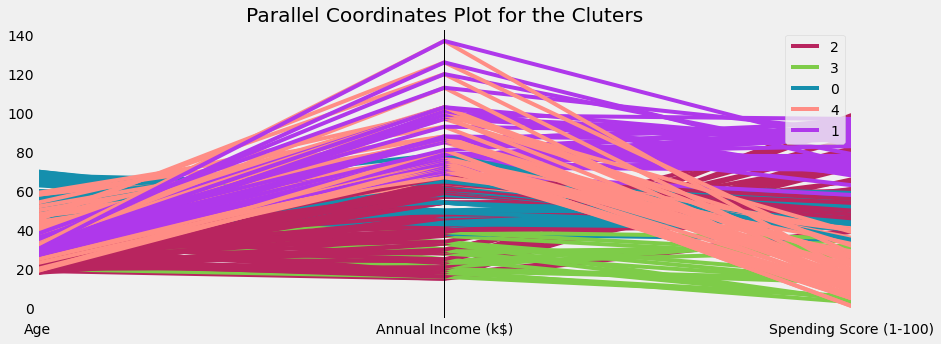

In [11]:
kmeans1 = KMeans(n_clusters= 5, init='k-means++', random_state=42)
kmeans1.fit(X1)

predict = kmeans1.predict(X1)
data['cluster'] = predict
color_codes=('#B8255F','#7ECC49','#158FAD','#FF8D85','#AF38EB')

plt.figure(1 , figsize = (13 ,5))
pd.plotting.parallel_coordinates(data, 'cluster',color=color_codes)
plt.title('Parallel Coordinates Plot for the Cluters')
plt.show()


In [12]:
#PARA VISUALIZAR MEJOR OCUPAR ESTO PQ SE GRAFICAN LOS CENTROIDES Y SE EENTIENDE MUUCHO MEJOR 
data.drop(columns=['cluster'],inplace=True)

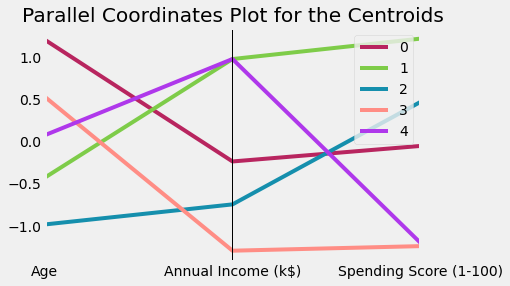

In [13]:
# Create a data frame containing our centroids
centroids = pd.DataFrame(kmeans1.cluster_centers_,columns=data.columns)
centroids['cluster'] = centroids.index

cent2=pd.plotting.parallel_coordinates(centroids,'cluster',color=color_codes)
plt.title('Parallel Coordinates Plot for the Centroids')
plt.show()